# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img
from typing import Tuple,List
import matplotlib.pyplot as plt
from scipy.linalg import null_space

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [ ]:
from typing import Tuple
def warp(H:np.array,p:Tuple):
    """
    Warp a point based on a given Homography matrix
    
    Returns:
        Tuple of points
    """
    x1,x2 = p
    x1, x2, x3 = H@np.array([x1,x2,1])
    if x3 != 0:
        return x1/x3, x2/x3
    return x1, x2

def apply_H(I:np.array, H:np.array):
    """
    Apply homography matrix to a given image
    
    Returns:
        transformed image
    """
    h,w,c = I.shape
    tl = warp(H,(0,0)) # top left
    tr = warp(H,(w,0)) # top right
    bl = warp(H,(0,h)) # bottom left
    br = warp(H,(w,h)) # bottom right
    corners = np.array([tl,tr,bl,br])

    #get min and max coordinates in the new space
    min_x = np.ceil(corners.min(axis=0)[0])
    max_x = np.floor(corners.max(axis=0)[0])
    min_y = np.ceil(corners.min(axis=0)[1])
    max_y = np.floor(corners.max(axis=0)[1])

    # get size of canvas
    width_canvas, height_canvas = max_x-min_x,max_y-min_y

    # generate a grid corresponding to new space coordinates
    xx,yy = np.meshgrid(np.arange(min_x,max_x),np.arange(min_y,max_y))

    # make a matrix with all new points in homogenous coordinates
    dstpointsH = np.array([xx.flatten(),yy.flatten(),np.ones_like(xx.flatten())])
    H_inv = np.linalg.inv(H)
    # map them back to their source points
    # src_pointsH in homogenous coordinates
    src_pointsH = np.matmul(H_inv,dstpointsH)

    # get src_x and src_y in meshgrid-like coordinates
    src_x = np.reshape(src_pointsH[0]/src_pointsH[2], xx.shape)
    src_y = np.reshape(src_pointsH[1]/src_pointsH[2], yy.shape)

    #draw canvas
    out = np.zeros((int(height_canvas),int(width_canvas),3))

    # using map_coordinates in by passing in a meshgrid is one of the best parts about this
    # function. You must be familiar with its input arguments to make the best use of it.
    for i in range(c):
        out[:,:,i] = map_coordinates(I[:,:,i],[src_y,src_x])
    return np.uint8(out)

In [ ]:
I = Image.open('../../Data/0000_s.png')
H = np.array([[1,-1,-0],
              [0.3,1,10],
              [0.001,0,1]])
#H = np.array(((1,0,0), (0,1,0), (0,0,1)))
I2 = apply_H(np.array(I), H)

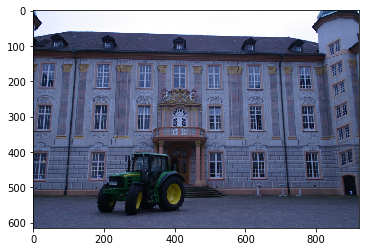

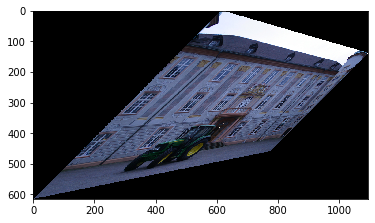

In [ ]:
plot_img(np.array(I))
plot_img(I2)

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

In [ ]:
def build_similarity_matrix(theta, scale, translation):
    """
    Build a similarity matrix from rotation, scaling and translation
    
    Args:
        theta: angle in degrees
        scale: number to scale
        translation: list/tuple/array with corresponding
            x and y coordinates to translate the axes to
    """
    # convert to radians
    theta = theta*np.pi/180
    matrix = np.array([[np.cos(theta)*scale, -np.sin(theta)*scale, translation[0]],
                        [np.sin(theta)*scale, np.cos(theta)*scale, translation[1]],
                        [0,0,1]])
    return matrix

In [ ]:
I = Image.open('../../Data/0000_s.png')
sim_matrix = build_similarity_matrix(45, 1.2, (1,5))
I2 = apply_H(np.array(I), sim_matrix)

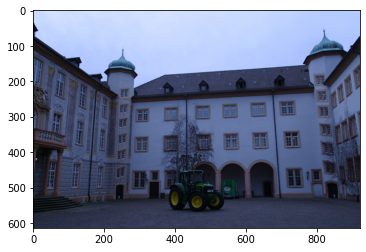

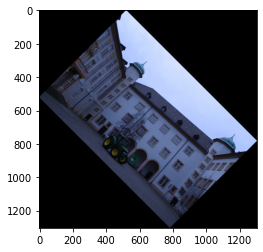

In [ ]:
plot_img(np.array(I))
plot_img(I2)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

In [ ]:
def build_affine_matrix(A, translation):
    """
    Build an affine matrix from a non-singular matrix A and translation t
    
    Args:
        A: a non-singular matrix A
        translation: list/tuple/array with corresponding
            x and y coordinates to translate the axes to
    """
    matrix = np.array([[A[0,0],A[0,1,], translation[0]],
                       [A[1,0], A[1,1], translation[1]],
                       [0,0,1]])
    return matrix

In [ ]:
A = np.array([[1, 0],[0.3, 1]])
t = [5,10]
A,t

(array([[1. , 0. ],
        [0.3, 1. ]]),
 [5, 10])

In [ ]:
affine_matrix = build_affine_matrix(A,t)
I_aff = apply_H(np.array(I), affine_matrix)

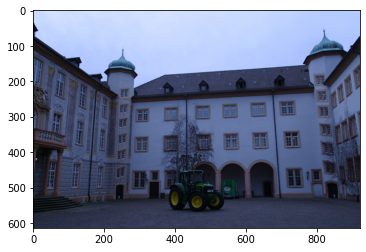

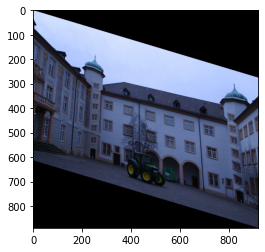

In [ ]:
plot_img(np.array(I))
plot_img(I_aff)

### Singular Value Decomposition 

$A=UDV^T$, such that $D$ is a diagonal matrix and $U$ and $V$ are orthogonal matrices.

Since $U$ and $V$ are orthogonal, A can be decomposed into rotations and non-isotropic scalings:

$UDV^T=(UV^T)(VDV^T)=R(\theta)(R(-\phi)DR(\phi))$

1. $R(\theta) = UV^T$

2. $R(\phi) = V^T$

In [ ]:
A = np.array([[1, 0],[0.3, 1]])
t = [5,10]
U,D,Vt = np.linalg.svd(A)

In [ ]:
R1 = U@Vt
R2 = Vt

In [ ]:
Hrot1 = np.array([[R1[0,0], R1[0,1], 0],
                  [R1[1,0], R1[1,1], 0],
                  [0, 0, 1]])

Hrot2 = np.array([[R2[0,0], R2[0,1], 0],
                  [R2[1,0], R2[1,1], 0],
                  [0, 0, 1]])

Hscale = np.array([[D[0], 0, 0],
                   [0, D[1], 0],
                   [0, 0, 1]])

Htrans = np.array([[1, 0, t[0]],
                  [0, 1, t[1]],
                  [0, 0, 1]])

In [ ]:
Hcombined = Htrans@Hrot1@(Hrot2.T)@Hscale@Hrot2;Hcombined

array([[1.00000000e+00, 1.68766181e-16, 5.00000000e+00],
       [3.00000000e-01, 1.00000000e+00, 1.00000000e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
affine_matrix = build_affine_matrix(A, t);affine_matrix

array([[ 1. ,  0. ,  5. ],
       [ 0.3,  1. , 10. ],
       [ 0. ,  0. ,  1. ]])

In [ ]:
def crop(I):
    """
    crop zero pixel areas that are not important
    """
    ys, xs = np.where((I[:,:,0] != 0) & (I[:,:,1] != 0) & (I[:,:,2] != 0))
    x0, y0, x, y = np.min(xs), np.min(ys), np.max(xs), np.max(ys)
    return I[y0:y, x0:x]

Perform step-by-step affine transformation

In [ ]:
I21 = apply_H(np.array(I),Hrot2)
I22 = crop(apply_H(np.array(I21),Hscale))
I23 = crop(apply_H(np.array(I22),Hrot2.T))
I24 = crop(apply_H(np.array(I23),Hrot1))
I25 = crop(apply_H(np.array(I24),Htrans))

compare it with the affine_matrix generated earlier

In [ ]:
Hcombined

array([[1.00000000e+00, 1.68766181e-16, 5.00000000e+00],
       [3.00000000e-01, 1.00000000e+00, 1.00000000e+01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
affine_matrix

array([[ 1. ,  0. ,  5. ],
       [ 0.3,  1. , 10. ],
       [ 0. ,  0. ,  1. ]])

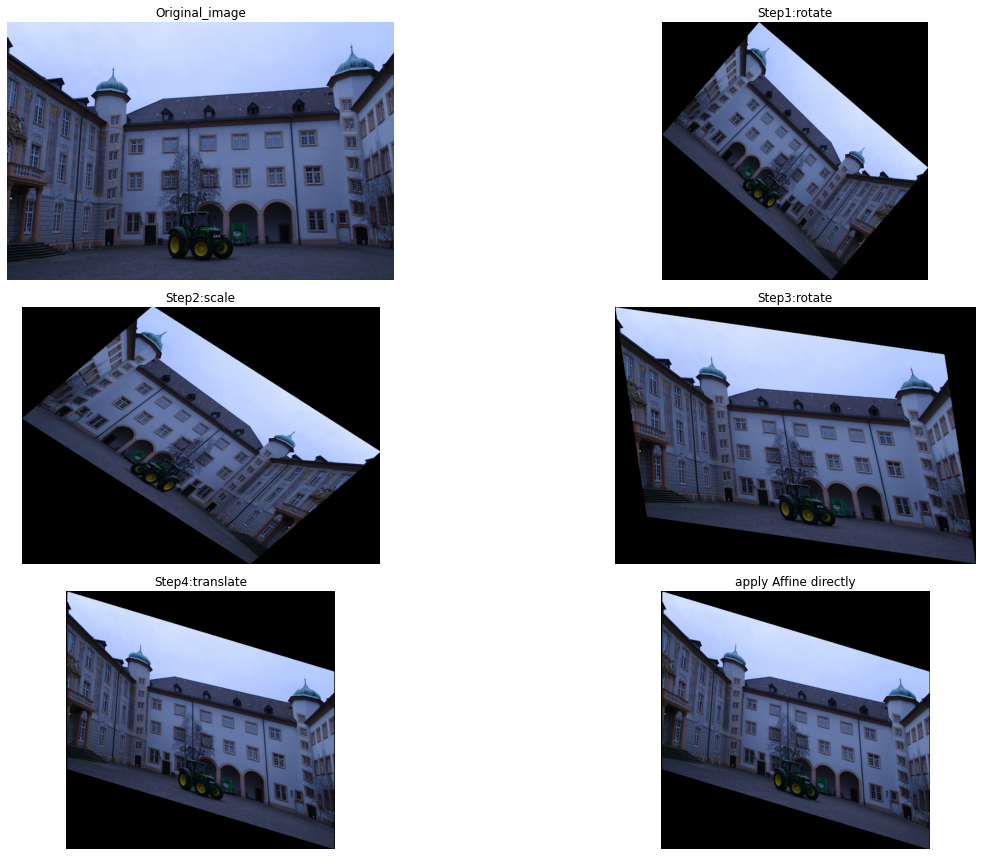

In [ ]:
fig,axes = plt.subplots(3,2, figsize=(20,12))
titles = ['Original_image','Step1:rotate','Step2:scale','Step3:rotate','Step4:translate','apply Affine directly']
images = [np.array(I), I21, I22, I23, I24, I25]
for ax, image, title in zip(axes.flatten(), images, titles):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
I2 = apply_H(np.array(I), Hcombined)
I3 = apply_H(np.array(I),affine_matrix)

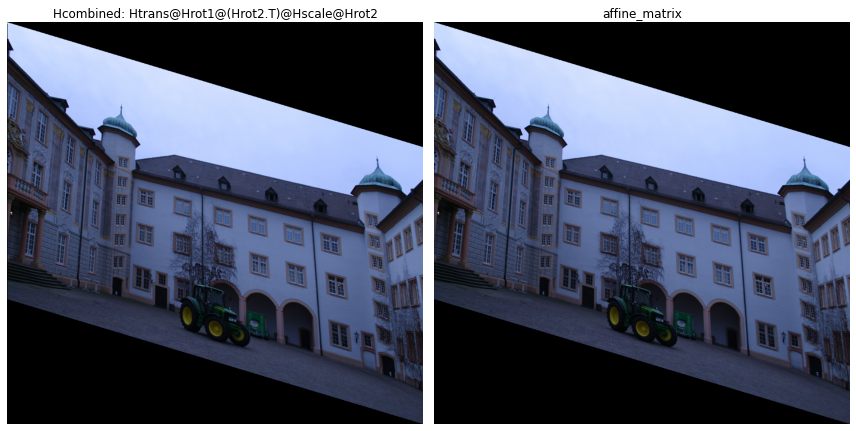

In [ ]:
fig,axes = plt.subplots(1,2, figsize=(12,8))
titles = ['Hcombined: Htrans@Hrot1@(Hrot2.T)@Hscale@Hrot2', 'affine_matrix']
images = [I2, I3]
for ax, image, title in zip(axes.flatten(), images, titles):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

In [ ]:
def build_homography_matrix(A, translation, v):
    """
    Build a homography matrix from a non-singular matrix A, translation t and v
    
    Args:
        A: a non-singular matrix A
        translation: list/tuple/array with corresponding
            x and y coordinates to translate the axes to
        v: responsible for mapping lines at infinity to
            other points
    """
    matrix = np.array([[A[0,0],A[0,1,], translation[0]],
                       [A[1,0], A[1,1], translation[1]],
                       [v[0],v[1],1]])
    return matrix

In [ ]:
A = np.array([[1, 0],[0.3, 1]])
t = [5,10]
v = [0.002, 0.001]

In [ ]:
homography_matrix = build_homography_matrix(A,t,v);homography_matrix

array([[1.e+00, 0.e+00, 5.e+00],
       [3.e-01, 1.e+00, 1.e+01],
       [2.e-03, 1.e-03, 1.e+00]])

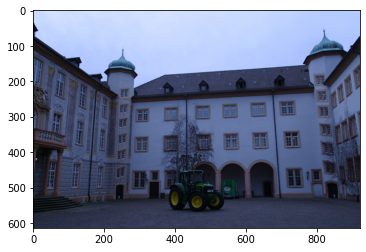

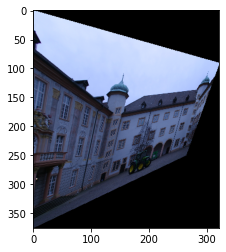

In [ ]:
#H = ... # complete

I_proj = apply_H(np.array(I), homography_matrix)

plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [ ]:
# load images and lines
img_path = "../../Data/0000_s.png"
I = Image.open(img_path)

lines_path = "../../Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [ ]:
l1 = np.cross(p1, p2)
l2 = np.cross(p3, p4)
l3 = np.cross(p5, p6)
l4 = np.cross(p7, p8)

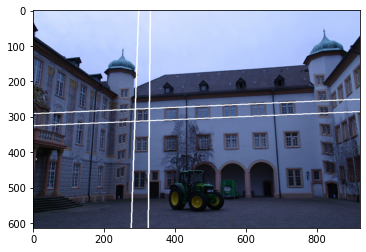

In [ ]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>
ToDo: 

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>
ToDo: 
**better rephrase more precisely (see two options and also expression of line slope)**    

In [ ]:
vanish_pt1 = np.cross(l1, l2)
vanish_pt2 = np.cross(l3, l4)

In [ ]:
vanish_pt1 /= vanish_pt1[2]
vanish_pt2 /= vanish_pt2[2]

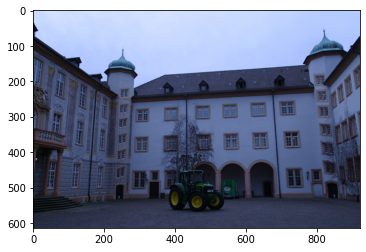

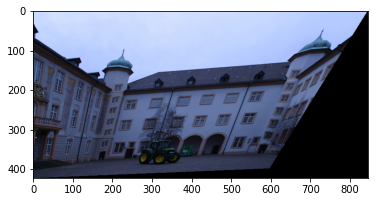

In [ ]:
line_inf = np.cross(vanish_pt1, vanish_pt2)
line_inf /= line_inf[2]

def build_affine_rect_matrix(l):
    matrix = np.array([[1, 0, 0],
                       [0, 1, 0],
                       [l[0], l[1], l[2]]])
    return matrix

H_affine_rect = build_affine_rect_matrix(line_inf)

# print(f'Vanishing pt1: {vanish_pt1}\n Vanish pt2: {vanish_pt2}\n Line at infinity: {line_inf}')
# print(H_affine_rect)

I_aff_rect = apply_H(np.array(I), H_affine_rect)

plot_img(I)
plot_img(I_aff_rect)

In [ ]:
H_aff_rect_lines = np.transpose(np.linalg.inv(H_affine_rect))

lr1 = H_aff_rect_lines@l1
lr2 = H_aff_rect_lines@l2
lr3 = H_aff_rect_lines@l3
lr4 = H_aff_rect_lines@l4

In [ ]:
#export
def get_angle_from_lines(l, m):
    l = np.array([l[0]/l[2], l[1]/l[2]])
    m = np.array([m[0]/m[2],m[1]/m[2]])
    angle = np.arccos(np.dot(l,m)/np.linalg.norm(l,ord=2)/np.linalg.norm(m,ord=2))
    return angle*180/np.pi

Using either method for angle calculation works. Mathematically, they are the same.

In [ ]:
def get_angle_lines(l, m):
    '''
    Computes the angle between lines l and m, both defined Projective Geometry way
    '''
    l /= l[2]
    m /= m[2]
    omega_inf = np.eye(3)
    omega_inf[2,2] = 0

    orth_l = omega_inf@l
    orth_m = omega_inf@m

    return 180*np.arccos(orth_l.dot(m)/np.sqrt(orth_l.dot(l)*orth_m.dot(m)))/np.pi

In [ ]:
l = [1, 1, 1]
m = [1, 0, 1]
get_angle_from_lines(l,m)

45.00000000000001

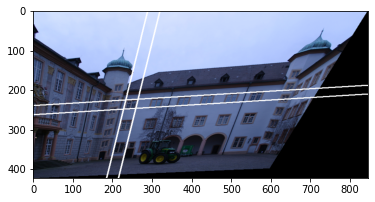

In [ ]:
# show the chosen lines in the image
I_aff_rect = apply_H(np.array(I), H_affine_rect)
I_aff_rect = Image.fromarray(I_aff_rect)
canv = ImageDraw.Draw(I_aff_rect)
point_color = (0, 0, 255)
line_draw(lr1, canv, I_aff_rect.size)
line_draw(lr2, canv, I_aff_rect.size)
line_draw(lr3, canv, I_aff_rect.size)
line_draw(lr4, canv, I_aff_rect.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I_aff_rect)
I = Image.open(img_path)

In [ ]:
print('Angles before transform')
print('θ(l1,l2) = ', get_angle_from_lines(l1, l2))
print('θ(l3,l4) = ', get_angle_from_lines(l3, l4))
print('θ(l1,l3) = ', get_angle_from_lines(l1, l3))

print('Angles after transform')
print('θ(lr1,lr2) = ', get_angle_from_lines(lr1, lr2))
print('θ(lr3,lr4) = ', get_angle_from_lines(lr3, lr4))
print('θ(lr1,lr3) = ', get_angle_from_lines(lr1, lr3))

Angles before transform
θ(l1,l2) =  0.09918160389665683
θ(l3,l4) =  1.3435373042187968
θ(l1,l3) =  85.45401946339824
Angles after transform
θ(lr1,lr2) =  nan
θ(lr3,lr4) =  0.0
θ(lr1,lr3) =  72.64082077686572
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.

In [ ]:
# load images and lines
img_path = "../../Data/0001_s.png"
I = Image.open(img_path)

lines_path = "../../Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

In [ ]:
def get_line_from_index(i):
    #account for zero indexing
    i = i-1
    p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
    p2 = [A[i, 2], A[i, 3], 1] # final point in line i
    l = np.cross(p1, p2)
    l = l/l[2]
    return l

In [ ]:
# these lines are better
l1 = get_line_from_index(315)
m1 = get_line_from_index(301)

l2 = get_line_from_index(614)
m2 = get_line_from_index(541)

l3 = get_line_from_index(188)
m3 = get_line_from_index(337)

l4 = get_line_from_index(284)
m4 = get_line_from_index(298)

l5 = get_line_from_index(645)
m5 = get_line_from_index(170)

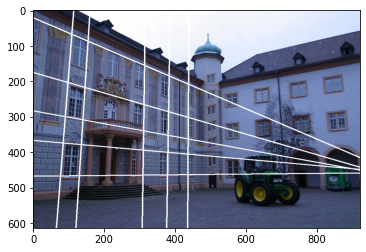

In [ ]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)
line_draw(l5, canv, I.size)

line_draw(m1, canv, I.size)
line_draw(m2, canv, I.size)
line_draw(m3, canv, I.size)
line_draw(m4, canv, I.size)
line_draw(m5, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

In [ ]:
def get_constraint_array(l, m):
    return np.array([l[0]*m[0], 
                     (l[0]*m[1]+l[1]*m[0])/2,
                     l[1]*m[1],
                    (l[0]*m[2]+l[2]*m[0])/2,
                     (l[1]*m[2]+l[2]*m[1])/2,
                     l[2]*m[2]])

In [ ]:
get_constraint_array(l1,m1)

array([-1.45125019e-05,  2.44226191e-05,  3.97169727e-06, -3.55549220e-03,
       -3.19986312e-03,  1.00000000e+00])

Form equations using 5 orthogonal lines

In [ ]:
eq1 = get_constraint_array(l1,m1)
eq2 = get_constraint_array(l2,m2)
eq3 = get_constraint_array(l3,m3)
eq4 = get_constraint_array(l4,m4)
eq5 = get_constraint_array(l5,m5)

In [ ]:
Eq = np.array([eq1, eq2, eq3, eq4, eq5])

In [ ]:
S = null_space(Eq);S[:,0]#show first (and only) value in null space

array([ 6.95423069e-01,  7.17302765e-01, -4.31333575e-02,  1.48918489e-03,
        8.91536017e-04,  8.92807529e-07])

In [ ]:
s = S[:,0]
a = s[0];
b = s[1];
c = s[2];
d = s[3];
e = s[4];
f = s[5]

In [ ]:
C = np.array([[a, b/2, d/2], [b/2, c, e/2], [d/2, e/2, f]]);C

array([[ 6.95423069e-01,  3.58651382e-01,  7.44592443e-04],
       [ 3.58651382e-01, -4.31333575e-02,  4.45768008e-04],
       [ 7.44592443e-04,  4.45768008e-04,  8.92807529e-07]])

In [ ]:
U,D,Vt = np.linalg.svd(C)

Is this how you form the homography matrix?

In [ ]:
H = U

In [ ]:
I_metr_rect = apply_H(np.array(I), H)

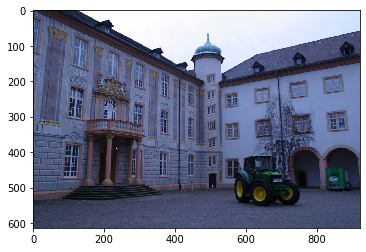

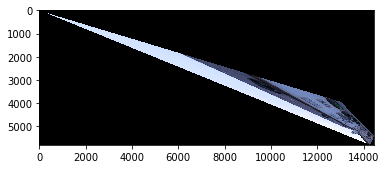

In [ ]:
plot_img(I)
plot_img(I_metr_rect)

In [ ]:
H_metric_rect_lines = np.transpose(np.linalg.inv(H))

lr1 = H_metric_rect_lines@l1
lr2 = H_metric_rect_lines@l2
lr3 = H_metric_rect_lines@l3
lr4 = H_metric_rect_lines@l4
lr5 = H_metric_rect_lines@l5

In [ ]:
mr1 = H_metric_rect_lines@m1
mr2 = H_metric_rect_lines@m2
mr3 = H_metric_rect_lines@m3
mr4 = H_metric_rect_lines@m4
mr5 = H_metric_rect_lines@m5

In [ ]:
get_angle_from_lines(l1,m1)

101.64409731762812

In [ ]:
get_angle_from_lines(lr1,mr1)

102.39540323437825